# Exercise
This week the assignment is to take the `startups_profit.csv` file and perform a variety of tasks in order to achieve the desired results. These are as follows:
1. Create a Neural Network that can predict profit
2. Report relevant metrics for this type of model

In [8]:
import pandas as pd, numpy as np, tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

base_path = Path()
profit_file = base_path.joinpath('startups_profit.csv')
profit_df = pd.read_csv(profit_file, skipinitialspace=True)
profit_df.columns = profit_df.columns.str.strip()
profit_df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,"$192,261.83"
1,162597.70,151377.59,443898.53,California,"$191,792.06"
2,153441.51,101145.55,407934.54,FL,"$191,050.39"
3,144372.41,118671.85,383199.62,New York,"$182,901.99"
4,142107.34,91391.77,366168.42,FL,"$166,187.94"


# Transforming the data
Before I subclass the datasets or build any models, first I want to transform the data how I need it to perform analysis. This involes the following steps:
1. First I take the profit column of the data and strip all `$` or `,` characters by replacing them with nothing. During this process I reformat the data as a float value
2. Next I create a copy of the original data - to preserve its integrity as I make further transformations.
3. I scale the new dataframe on a standard curve - this gives me a reformatted set of columns that create a standard distribution. This will improve model accuracy.

In [9]:
profit_df['Profit'] = profit_df['Profit'].str.replace('[$,]', '').astype(float)
scaled_df = profit_df.copy()
numerical_columns = scaled_df.drop(columns=['State'])
scaler = StandardScaler().fit_transform(numerical_columns)
scaled_df[['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']] = scaler

scaled_df.head()

C:\Users\sebas\AppData\Local\Temp\ipykernel_8812\1392422914.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  profit_df['Profit'] = profit_df['Profit'].str.replace('[$,]', '').astype(float)


,R&D Spend,Administration,Marketing Spend,State,Profit
0,2.016411,0.560753,2.153943,New York,2.011203
1,1.955860,1.082807,1.923600,California,1.999430
2,1.754364,-0.728257,1.626528,FL,1.980842
3,1.554784,-0.096365,1.422210,New York,1.776627
4,1.504937,-1.079919,1.281528,FL,1.357740


# Defining the model
Now that I have the dataset I have to create the model. The model is comprised of a few things, and as a whole is a subclass of the `tf.keras.Model` class which represents all network models in TensorFlow. There are two parts to this that I will cover in detail, the `__init__` portion and the `forward` porton.
1. The `__init__` method defines the structure of the neural network. Each layer is outlined below:
   1. `layers.Dense` is used to take the input features and produces an output according to the specific linear layer in question. `fc1` produces a number of outputs equal to the `hidden_size` whereas `fc2` takes the `hidden_size` and produces a number of outputs equal to the `output_size`
   2. `nn.ReLU` is used to introduce non-linearity in the model. It does so by taking each element and applying the function `max(0,x)` to it. In a sense it replaces all negative values to zero and keeps all positive values unchanged. 
2. The `call` method defines how the forward pass of the neural network will operate. In my case the following occurs:
   1. `X` is passed through the first layer `self.fc1` to create the hidden layer, which then has a ReLU activation applied to it in this process. This is the main difference between PyTorch and TensorFlow.
   2. Lastly the `out` tensor is passed through the last linear layer `self.fc2` to produce the final output which is returned. 

In [10]:
class ProfitPredictor(tf.keras.Model):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProfitPredictor, self).__init__()
        self.fc1 = layers.Dense(hidden_size, activation='relu')
        self.fc2 = layers.Dense(output_size)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out


# Creating a dataset
Before I can create a model, first I have to further transform the data to make it usable in PyTorch. This means I have to subclass the dataset. I did so in the following steps:
1. First I created two values, an `X` value comprised of the spending columns and a `y` value comprised of the profit values
2. Next I had to take the States column and encode it to numbers. I did this with a One-Hot encoding method to create a matrix of True (1) or False (0) values. 
3. Now that I have the matrix I don't need the state column so I drop it.
4. Finally I have to transform them into the datatype that TensorFlow uses, so I wrap the variables with the `from_tensor_slices` method.

In [11]:
# Define the TensorFlow dataset
class ProfitDataset(tf.data.Dataset):
    def __new__(cls, data):
        X = data[['R&D Spend', 'Administration', 'Marketing Spend']]
        y = data['Profit'].values

        # Convert the categorical variable to one-hot encoding
        states = pd.get_dummies(data['State'])
        X = pd.concat([data, states], axis=1).drop(columns=['State']).values
        return tf.data.Dataset.from_tensor_slices((X, y))

In [12]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(scaled_df, test_size=0.2, random_state=42)

# Instantiate the datasets and dataloaders
train_dataset = ProfitDataset(train_data)
test_dataset = ProfitDataset(test_data)
train_dataloader = train_dataset.batch(8).shuffle(True)
test_dataloader = test_dataset.batch(8).shuffle(True)

# Train/Test Model
Finally with out hyperparameters we will process the data against the model. In this case I also track the loss and plot it when its done to get an idea of the loss with this parameters.
In the testing section I also extract all data, including the predictions, into a dataframe for viewing and calculating the R2 score afterwards.

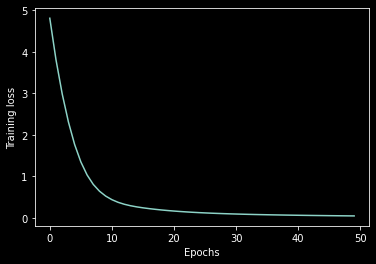

In [13]:
# Define the model parameters
input_size = train_dataset.element_spec[0].shape[0]
hidden_size = 64
output_size = 1
lr = 0.001
epochs = 50

# Instantiate the model and the optimizer
model = ProfitPredictor(input_size, hidden_size, output_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
criterion = tf.keras.losses.MeanSquaredError()

loss_data = []
# Train the model
for epoch in range(epochs):
    train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = criterion(y_pred, y_batch)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss += loss.numpy()
    loss_data.append(train_loss)

import matplotlib.pyplot as plt

plt.plot(range(epochs), loss_data)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

pred_df = pd.DataFrame()
# Evaluate the model
test_loss = 0
for X_batch, y_batch in test_dataloader:
    y_pred_test = model(X_batch, training=False)
    test_loss += criterion(y_pred_test, y_batch).numpy()
    X_batch = X_batch.numpy()
    y_batch = y_batch.numpy()
    y_pred_test = y_pred_test.numpy()

    # Extract the state information from the one-hot encoding
    states = ['California', 'Florida', 'New York']
    state_idx = np.argmax(X_batch[:,3:6], axis=1)
    state = [states[i] for i in state_idx]

    # Add the results to the DataFrame
    batch_df = pd.DataFrame({'R&D Spend': X_batch[:,0], 'Administration': X_batch[:,1], 'Marketing Spend': X_batch[:,2], 'State': state, 'Profit': y_batch, 'Predicted': y_pred_test[:,0]})
    pred_df = pd.concat([pred_df, batch_df], ignore_index=True)

In [14]:
display(pred_df)
r2 = r2_score(pred_df['Profit'], pred_df['Predicted'])
print(f'R2 score: {r2:.2f}')

,R&D Spend,Administration,Marketing Spend,State,Profit,Predicted
0,0.402078,0.510179,0.343957,Florida,0.558750,0.492027
1,-0.773820,-1.383122,-0.297583,Florida,-0.777094,-0.837221
2,-0.258074,-0.205629,-0.990357,New York,-0.302625,-0.325206
3,-1.600350,0.101254,-1.727400,Florida,-1.180082,-1.216299
4,0.460720,0.855666,0.591017,California,0.334771,0.301677
5,-1.610433,-2.509409,-1.743127,Florida,-1.913212,-1.834887
6,0.035370,0.821718,-0.635835,New York,-0.157367,-0.084740
7,-0.199312,0.656489,-0.603517,Florida,-0.115493,-0.294604
8,-0.226949,0.283924,-1.362450,Florida,-0.365524,-0.506231
9,0.279442,1.159837,-1.743127,California,0.269773,0.192856


R2 score: 0.98
